In [200]:
%matplotlib inline

from collections import namedtuple
from contextlib import contextmanager
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np
import pandas as pd
from pypika import functions as fn
from pypika import MySQLQuery as Query, Table
from pypika.terms import CustomFunction, Function, Term
import re
from scipy.stats import norm
import statsmodels.api as sm

figsize(12.5, 4)

In [201]:
@contextmanager
def managed_cnx():
        cnx = mysql.connector.connect(
            user='root', password='root',
            database='twitter', charset='utf8mb4')
        try:
            yield cnx
        finally:
            cnx.close()

@contextmanager
def managed_cursor(**kwargs):
    with managed_cnx() as cnx:
        cursor = cnx.cursor(**kwargs)
        try:
            yield cursor
        finally:
            cursor.close()

In [202]:
with managed_cursor() as cursor:
    cursor.execute(str(Query.from_('tweets').select(fn.Count('*'))))
    print(cursor.fetchone())

(1217711,)


In [203]:
UnixTimestamp = CustomFunction('unix_timestamp', ['date'])
FromUnixtime = CustomFunction('from_unixtime', ['unixtime'])
ConvertTz = CustomFunction('convert_tz', ['dt', 'from_tz', 'to_tz'])

In [204]:
tweets, users = Table('tweets'), Table('users')

In [205]:
KeywordTrajectory = namedtuple('KeywordTrajectory', ['created_at', 'count'])

# TODO: keyword による絞り込み
def keyword_trajectory(cursor, truncated_by='10 minutes'):
    minutes = re.sub(r'^(\d+)\s+minutes$', r'\1', truncated_by)
    assert(minutes.isdecimal())
    seconds = 60 * int(minutes)

    created_at_alias = 'truncated_by_{}min'.format(minutes)
    created_at = ConvertTz(FromUnixtime(fn.Floor(
            UnixTimestamp(tweets.created_at) / seconds) * seconds),
            'GMT', 'Asia/Tokyo')

    s = Query.from_(tweets) \
    .select(
        created_at.as_(created_at_alias),
        fn.Count(tweets.id)) \
    .groupby(created_at_alias)
    
    print('SQL: {}'.format(s))
    cursor.execute(str(s))

    return [KeywordTrajectory._make(r) for r in cursor]

In [206]:
with managed_cursor(buffered=True) as cursor:
    df = pd.DataFrame(data=keyword_trajectory(cursor, truncated_by='10 minutes'))
    df = df.set_index('created_at')
    print(df.head())
    print(df.tail())

SQL: SELECT convert_tz(from_unixtime(FLOOR(unix_timestamp(`created_at`)/600)*600),'GMT','Asia/Tokyo') `truncated_by_10min`,COUNT(`id`) FROM `tweets` GROUP BY `truncated_by_10min`
                     count
created_at                
2020-03-26 18:00:00    617
2020-03-26 18:10:00   1603
2020-03-26 18:20:00   2491
2020-03-26 18:30:00   2448
2020-03-26 18:40:00   2637
                     count
created_at                
2020-04-01 00:00:00   1486
2020-04-01 00:10:00   1324
2020-04-01 00:20:00   1311
2020-04-01 00:30:00     77
2020-04-01 02:20:00    417


In [207]:
since, until = '2020-03-27 00:00:00', '2020-04-01 00:00:00'
df = df.loc[since:until]

「緊急事態宣言」と「ロックダウン」のツイート数の時系列推移

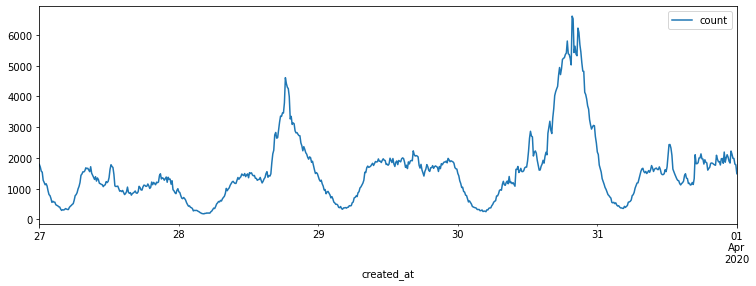

In [208]:
fig, ax = plt.subplots()
df.plot(kind='line', ax=ax)

In [216]:
#df['trend'] = trend
df.to_csv('data/search.csv')

## モデリング

### ローカル線形トレンドモデルの推定

In [241]:
model_lt = sm.tsa.UnobservedComponents(
    df['count'],
    level='local linear trend')

res_lt = model_lt.fit()
print(res_lt.summary())

                        Unobserved Components Results                         
Dep. Variable:                  count   No. Observations:                  721
Model:             local linear trend   Log Likelihood               -4664.147
Date:                Fri, 03 Apr 2020   AIC                           9334.294
Time:                        13:16:31   BIC                           9348.028
Sample:                    03-27-2020   HQIC                          9339.596
                         - 04-01-2020                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    42.8890    608.409      0.070      0.944   -1149.571    1235.349
sigma2.level      2.301e+04   1349.037     17.053      0.000    2.04e+04    2.56e+04
sigma2.trend       173.9664 

/home/p-baleine/.local/share/virtualenvs/fabrication_of_state_of_emergency_20200330-PMno-HTX/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


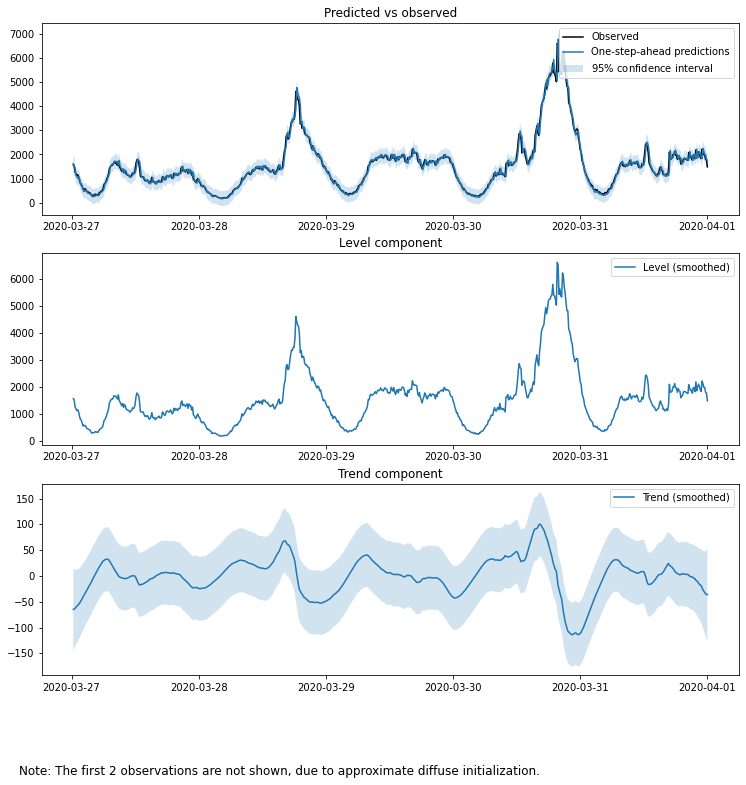

In [242]:
fig = res_lt.plot_components(figsize=(12.5, 12))

### 季節変動ありのローカル線形トレンドモデルの推定

In [243]:
seasonal = 24 * 60 // 10
assert(df['2020-03-28 00:00:00':'2020-03-29 00:00:00'].iloc[:-1].shape[0] == seasonal)

model_seasonal= sm.tsa.UnobservedComponents(
    df['count'],
    level='local linear trend',
    seasonal=seasonal)

res_lt_seasonal = model_seasonal.fit(
    start_params=model_seasonal.fit().params,)
print(res_lt_seasonal.summary())

/home/p-baleine/.local/share/virtualenvs/fabrication_of_state_of_emergency_20200330-PMno-HTX/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  warnings.warn('No frequency information was'


                            Unobserved Components Results                             
Dep. Variable:                          count   No. Observations:                  721
Model:                     local linear trend   Log Likelihood               -3816.308
                   + stochastic seasonal(144)   AIC                           7640.617
Date:                        Fri, 03 Apr 2020   BIC                           7658.041
Time:                                13:23:02   HQIC                          7647.412
Sample:                            03-27-2020                                         
                                 - 04-01-2020                                         
Covariance Type:                          opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular   950.3638    920.987      1.0

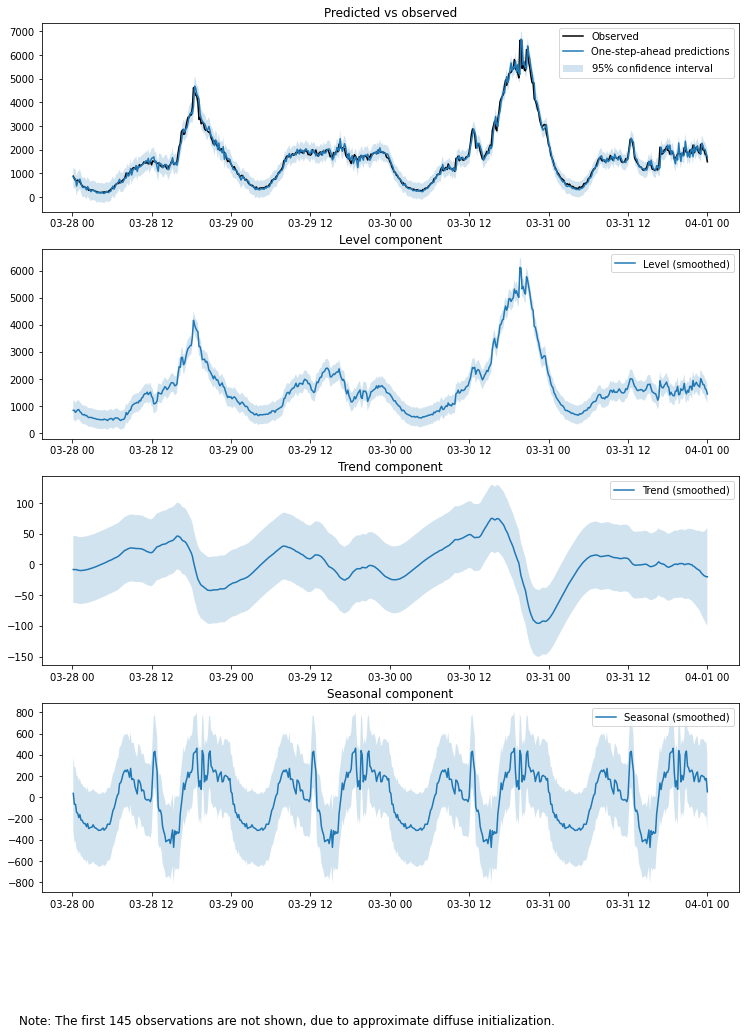

In [245]:
fig = res_lt_seasonal.plot_components(figsize=(12.5, 16))

In [262]:
def prediction_df(model_result):
    df = pd.DataFrame(
        {'value': model_result.level['smoothed'] + model_result.trend['smoothed']},
        index=search_df.index)
    signals = (df['value'].diff() > 0.0).astype(np.int32).diff().fillna(0.0)
    df.loc[:, 'signals'] = signals.shift(-1)
    return df


def plot_model_result_filter_seasonal(df, pred_df, depict_observation=True):
    fig, ax1 = plt.subplots()

    if depict_observation:
        color = 'tab:red'
        ax1.set_xlabel('created_at')
        ax1.set_ylabel('count', color=color)
        ax1.plot(df.index, df['count'], color=color)
        ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()

    color = 'tab:blue'
    ax2.set_ylabel('level + trend', color=color)
    ax2.plot(pred_df['value'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    ax2.plot(pred_df['value'].loc[pred_df['signals'] == 1.0],
        '^', markersize=6, color='r', alpha=0.2)

    ax2.plot(pred_df['value'].loc[pred_df['signals'] == -1.0],
        'v', markersize=6, color='b', alpha=0.2)

    fig.tight_layout()
    
    return fig, ax1, ax2

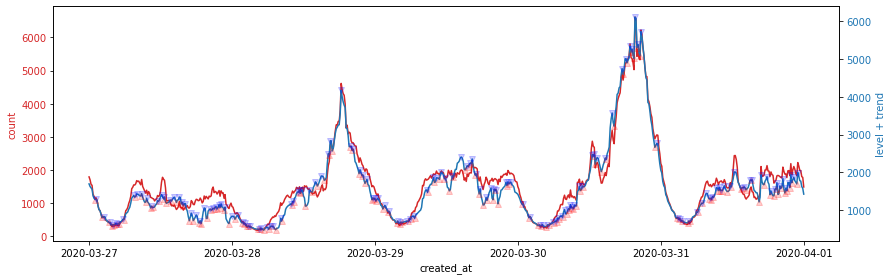

In [249]:
figsize(12.5, 4)

pred_df = prediction_df(res_lt_seasonal)
_ = plot_model_result_filter_seasonal(df, pred_df)

In [250]:
search_df = df
search_df['predicted'] = pred_df['value']
search_df['signals'] = pred_df['signals']
search_df.to_csv('data/search.csv')

## 拡散したツイートの確認

A Field Guide to "Fake News"より、

```
While online and platform metrics often serve to take measure of engagement by
means of what Theodore Porter calls “thin descriptions”[11] – i.e. aggregated
quantities such as total likes, shares, posts – we suggest different ways of
exploring how different publics engage with and ascribe meaning to fake news and
how this moves and mobilises different actors in the process.
```

試しに、retweet 数で足切りした上で、時系列にその tweet を並べてみたい。
まず、retweet 数の分布をしりたい

In [251]:
Tweet = namedtuple('Tweet', ['id', 'retweet_count', 'created_at', 'url', 'screen_name', 'text'])

def list_tweets(cursor):
    created_at = ConvertTz(tweets.created_at, 'GMT', 'Asia/Tokyo')

    s = Query.from_(tweets) \
    .join(users) \
    .on(tweets.tweeted_by == users.id) \
    .select(
        tweets.id,
        tweets.retweet_count,
        ConvertTz(tweets.created_at, 'GMT', 'Asia/Tokyo'),
        tweets.text,
        users.screen_name,
        fn.Concat('https://twitter.com/', users.screen_name, '/status/', tweets.id).as_('url'),
    ) \
    .where(Term.isnull(tweets.retweeted_status))  # オリジナルのみ

    print('SQL: {}'.format(s))
    cursor.execute(str(s))
    
    return [Tweet._make(r) for r in cursor]

In [252]:
with managed_cursor(buffered=True) as cursor:
    data = list_tweets(cursor)
    df = pd.DataFrame(data=data)
    df = df.set_index('created_at')
    print(df.head())

SQL: SELECT `tweets`.`id`,`tweets`.`retweet_count`,convert_tz(`tweets`.`created_at`,'GMT','Asia/Tokyo'),`tweets`.`text`,`users`.`screen_name`,CONCAT('https://twitter.com/',`users`.`screen_name`,'/status/',`tweets`.`id`) `url` FROM `tweets` JOIN `users` ON `tweets`.`tweeted_by`=`users`.`id` WHERE `tweets`.`retweeted_status` IS NULL
                                      id  retweet_count  \
created_at                                                
2020-03-31 20:50:11  1244955146330628096              0   
2020-03-26 21:24:18  1243151790721265665              0   
2020-03-30 15:02:40  1244505303946629120              0   
2020-03-30 16:28:52  1244526993904766976              1   
2020-03-28 18:57:20  1243839584368078848              0   

                                                                   url  \
created_at                                                               
2020-03-31 20:50:11  日本政府、緊急事態宣言について「感染者数や経済影響見極め慎重に判断」 https://t.c...   
2020-03-26 21:24:18  ロックダウンがスーパ

In [253]:
df.count()

id               287390
retweet_count    287390
url              287390
screen_name      287390
text             287390
dtype: int64

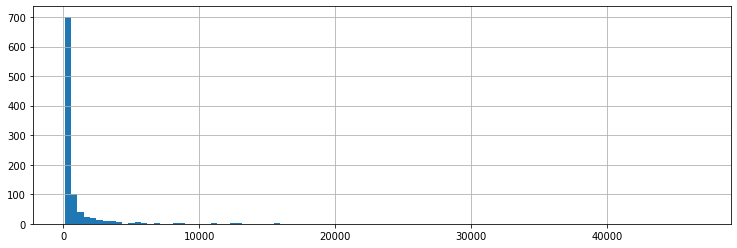

In [254]:
fig, ax = plt.subplots()
df[(100 < df['retweet_count'])]['retweet_count'].hist(ax=ax, bins=100)

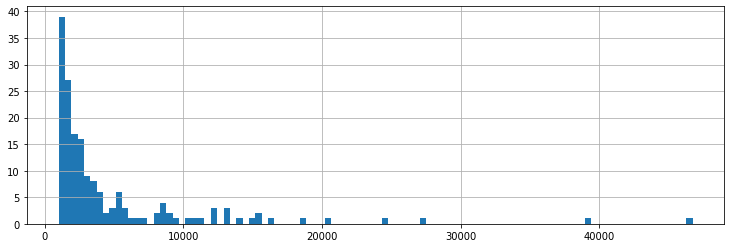

In [255]:
fig, ax = plt.subplots()
df[df['retweet_count'] > 1_000]['retweet_count'].hist(ax=ax, bins=100)

In [256]:
df[df['retweet_count'] > 1_000].count()

id               168
retweet_count    168
url              168
screen_name      168
text             168
dtype: int64

In [257]:
df[df['retweet_count'] > 1_000].head()

,id,retweet_count,url,screen_name,text
created_at,,,,,
2020-03-27 17:32:11,1243455766884831233,3599,いきなり「外出控えろ自粛しろあとは知らん」って放り出され、挙句にいつか都市封鎖するかもよって...,37_2_le_matin,https://twitter.com/37_2_le_matin/status/12434...
2020-03-28 20:22:58,1243861132936241154,10509,ロックダウン中のイタリア、室内で優しく楽しく、社会を励ますかのように踊りながらバイオリンを奏...,7_color_world,https://twitter.com/7_color_world/status/12438...
2020-03-29 16:26:43,1244164065653452800,1093,パリの街角をカモが悠々とお散歩、都市封鎖で人影なく https://t.co/pSonydK7ke,afpbbcom,https://twitter.com/afpbbcom/status/1244164065...
2020-03-31 23:50:14,1245000458458091521,18514,ドイツ人へ。面白くないとか、ドイツ語難しいとか、書類ばっかりで融通効かないとか文句ばっかり言...,AineFujioka,https://twitter.com/AineFujioka/status/1245000...
2020-03-31 12:19:31,1244826633292460032,2451,都市封鎖されているウェールズの街に山羊たちが降りてきた！ https://t.co/aPV3...,akasakapatricia,https://twitter.com/akasakapatricia/status/124...


In [258]:
df_gt_1_000_retweets = df[df['retweet_count'] > 1_000]

In [259]:
# import hashlib

# def naive_hash(text):
#     return hashlib.sha1(text.encode('utf-8')).hexdigest()

# df_gt_1_000_retweets.drop('id', axis=1, inplace=True)
# df_gt_1_000_retweets.loc[:, 'screen_name'] = \
#     df_gt_1_000_retweets.loc[:, 'screen_name'].map(naive_hash)

In [260]:
df_gt_1_000_retweets.to_csv('data/over_1_000_retweets.csv')

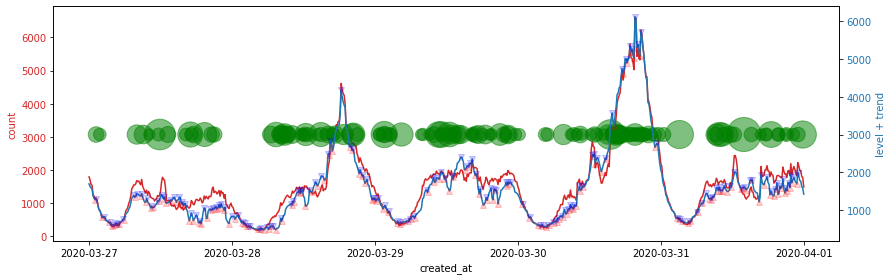

In [261]:
_, _, ax2 = plot_model_result_filter_seasonal(search_df, pred_df)

trimed = df_gt_1_000_retweets[since:until]

ax2.scatter(trimed.index, trimed['retweet_count'] * 0 + 3000,
            s=2 * 4 ** np.log10(trimed['retweet_count']),
           c='g', alpha=.5)

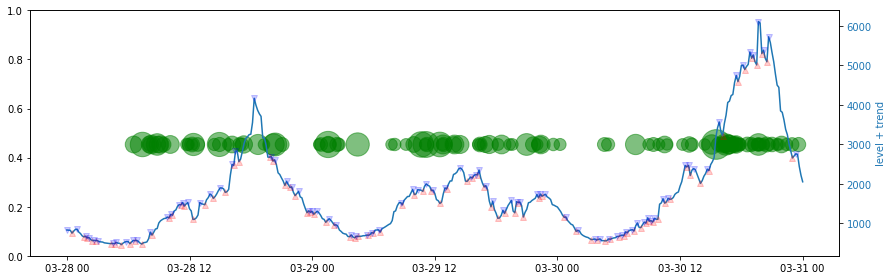

In [268]:
since, until = '2020-03-28 00:00:00', '2020-03-31 00:00:00'

_, _, ax2 = plot_model_result_filter_seasonal(
    search_df[since:until], pred_df[since:until], depict_observation=False)

trimed = df_gt_1_000_retweets[since:until]

ax2.scatter(trimed.index, trimed['retweet_count'] * 0 + 3000,
            s=2 * 4 ** np.log10(trimed['retweet_count']),
           c='g', alpha=.5)